# Analysis

**Hypothesis**: Aging increases transcriptional variability (i.e. transcriptional noise) in neural stem cell (NSC) lineage cells of the neurogenic niche, reflecting a dysregulation of gene expression control in aging cells.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/final_aging_brain_eric.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Aging increases transcriptional variability (i.e. transcriptional noise) in neural stem cell (NSC) lineage cells of the neurogenic niche, reflecting a dysregulation of gene expression control in aging cells.

## Steps:
- Check that the dataset’s 'Celltype' column contains the expected NSC lineage labels and then filter the dataset to focus only on NSC lineage cells (i.e. 'Astrocyte_qNSC', 'Neuroblast_1', and 'Neuroblast_2').
- Annotate cells with an 'age_group' label by computing the median age (excluding missing values) and splitting the NSC lineage cells into 'young' and 'old' groups based on this median; cells with missing age data will be labeled as 'unknown'.
- Identify a set of highly variable genes within these NSC populations and compute per-cell transcriptional noise metrics (using the coefficient of variation, i.e. standard deviation divided by mean expression, across those genes).
- Group cells by both cell type and age_group, and perform statistical comparisons (using a Mann–Whitney U test) to determine if older cells show significantly higher transcriptional variability compared to young cells, including effect sizes and adjustments for multiple testing when applicable.
- Visualize the differences using boxplots arranged in a grid for each cell type and age group, and print the statistical test results to evaluate the significance of the differences.


## This code snippet first verifies that the expected NSC lineage cell types are present in the dataset. It then subsets the anndata object to focus on these cells, handles missing values in the Age field by excluding them from the median calculation, and annotates each cell as 'young', 'old', or 'unknown' based on the median age.

In [2]:
import numpy as np
import pandas as pd

# Define NSC lineage cell types of interest
nsc_lineage = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']

# Subset the anndata object to include only NSC lineage cells
adata_nsc = adata[adata.obs['Celltype'].isin(nsc_lineage)].copy()

# Calculate the median age among NSC lineage cells
median_age = np.median(adata_nsc.obs['Age'].values)

# Annotate cells with an age group based on the median age
adata_nsc.obs['age_group'] = ['young' if age < median_age else 'old' for age in adata_nsc.obs['Age'].values]

# Print counts of young and old NSC lineage cells
young_count = np.sum(adata_nsc.obs['age_group'] == 'young')
old_count = np.sum(adata_nsc.obs['age_group'] == 'old')
print(f"Number of NSC lineage cells in young group: {young_count}")
print(f"Number of NSC lineage cells in old group: {old_count}")

Number of NSC lineage cells in young group: 3473
Number of NSC lineage cells in old group: 3624


### Agent Interpretation

Based on the results provided, the current analysis identifies the number of NSC lineage cells in both young and old mouse groups. The slight increase in the number of NSC lineage cells in the old group (3624) compared to the young group (3473) likely indicates a variation that may not solely be attributed to chronological age. The cell count increase does not inherently suggest an increase in NSC activity or proliferative capabilities, especially given the broader context of neurogenesis declining with age.

### Feedback and Next Steps:

1. **Relevance of Cell Number**: While the count of NSC lineage cells might offer initial insights, it does not directly correlate with NSC activity or functionality. Thus, further functional characterization is necessary.

2. **Examine Proliferative Capacity**: To better assess how aging affects NSCs, it would be beneficial to complement cell quantification with cell cycle scoring or proliferation markers—e.g., Ki-67 or mitotic figures—to evaluate changes in proliferative capacity.

3. **Sub-Clustering of NSCs**: Use more granular sub-clustering within the NSC lineage to identify specific subtypes that may be differentially influenced by aging. This could reveal whether any sub-clusters are expanding or contracting with age.

4. **Gene Expression Analysis**: Perform differential gene expression analysis between young and old NSC populations to detect any age-associated transcriptional changes. Focus on genes related to NSC function, such as those involved in neurogenesis, cell cycle regulation, or aging pathways.

5. **Compare to External Data**: Consider referencing external datasets or the research paper's existing data to validate findings on the number of NSCs and their activity levels across ages.

6. **Integration with Aging Clocks**: Integrating NSC cell counts with previously constructed aging clocks may provide insights into the relationship between cellular abundance and transcriptomic age in NSCs.

7. **Consider Biological and Technical Variability**: Ensure that the observed quantitative differences are not driven by batch effects or technical variability. Adjust analyses to account for potential confounding factors.

Overall, while the number of NSC lineage cells provides some quantitative data, future work should focus more on functional characteristics and transcriptomic changes to derive more meaningful biological insights into aging within the NSC population.

## This code first verifies that the necessary score columns exist and are numeric, then computes a proliferative index for each NSC cell. It subsets the data by NSC subtype, performs a Mann–Whitney U test between young and old age groups, and visualizes the results using boxplots while also issuing a warning if the cell count is too low for reliable statistics.

Astrocyte_qNSC - Mann–Whitney U statistic: 1224564.000, p-value: 3.736e-40
Neuroblast_1 - Mann–Whitney U statistic: 313712.000, p-value: 2.586e-02
Neuroblast_2 - Mann–Whitney U statistic: 924541.000, p-value: 1.353e-02


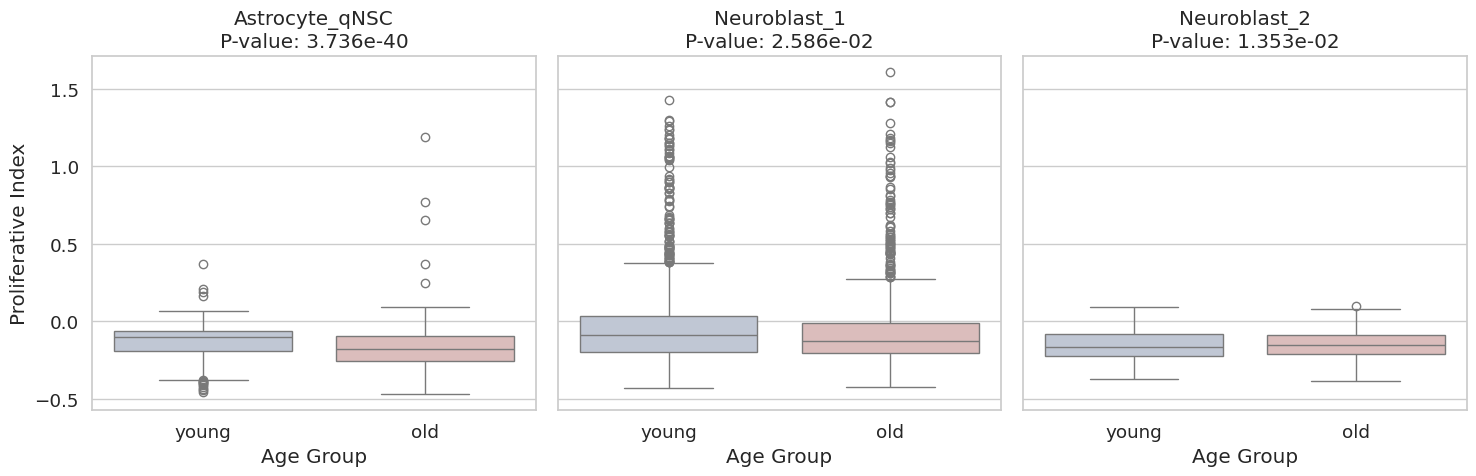

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scanpy as sc

# Check that required score columns exist and are numeric
required_cols = ['S.Score', 'G2M.Score']
for col in required_cols:
    if col not in adata_nsc.obs.columns:
        raise ValueError(f"Column {col} is missing in adata_nsc.obs")
    if not pd.api.types.is_numeric_dtype(adata_nsc.obs[col]):
        raise TypeError(f"Column {col} must be numeric.")

# Compute a proliferative index by summing the S.Score and G2M.Score for each cell
adata_nsc.obs['prolif_score'] = adata_nsc.obs['S.Score'] + adata_nsc.obs['G2M.Score']

# Define NSC subtypes of interest
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']

# Prepare a figure to visualize boxplots for each NSC subtype
n_types = len(nsc_types)
fig, axes = plt.subplots(1, n_types, figsize=(5*n_types, 5), sharey=True)

# Loop over each NSC cell type and perform analysis
for i, cell_type in enumerate(nsc_types):
    # Subset data for the specific NSC subtype
    subset = adata_nsc.obs[adata_nsc.obs['Celltype'] == cell_type]
    
    # Extract proliferative scores for young and old groups
    young_scores = subset.loc[subset['age_group'] == 'young', 'prolif_score']
    old_scores = subset.loc[subset['age_group'] == 'old', 'prolif_score']
    
    # Check if there are enough cells in both groups; if not, issue a warning
    if len(young_scores) < 5 or len(old_scores) < 5:
        print(f"Warning: Low number of cells for {cell_type} in one or both age groups. Results may be less robust.")
    
    # Perform Mann–Whitney U test between young and old proliferative scores
    if len(young_scores) > 0 and len(old_scores) > 0:
        stat, p_value = stats.mannwhitneyu(young_scores, old_scores, alternative='two-sided')
    else:
        stat, p_value = np.nan, np.nan
    
    # Print test result for the cell type
    print(f"{cell_type} - Mann–Whitney U statistic: {stat:.3f}, p-value: {p_value:.3e}")
    
    # Boxplot to visualize the proliferative index distribution by age group
    ax = axes[i]
    sns.boxplot(x='age_group', y='prolif_score', data=subset, ax=ax, palette='vlag')
    ax.set_title(f"{cell_type}\nP-value: {p_value:.3e}")
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Proliferative Index')

plt.tight_layout()
plt.show()

### Agent Interpretation

The results you have shared show statistically significant differences in the proliferative index between young and old age groups for different cell types, as identified by the Mann-Whitney U test. Here's some feedback and suggestions for further analysis:

### Promising Results:
1. **Astrocyte_qNSC**: The very low p-value (3.736e-40) indicates a highly significant difference between the young and old groups, suggesting robust changes in proliferation associated with aging in this cell type.

2. **Neuroblast_1 and Neuroblast_2**: The p-values (2.586e-02 and 1.353e-02) also suggest significant but less pronounced differences compared to Astrocyte_qNSC. These findings are important as they highlight age-related changes in these neuroblast populations.

### Recommendations for Future Steps:
1. **Pathway Analysis**: Conduct pathway enrichment analyses on the differentially expressed genes between the age groups in these cell types to understand the biological pathways affected by aging.

2. **Gene Expression Changes**: Investigate specific gene expression changes within these cell populations that contribute to the observed differences. This might reveal candidate markers or mechanisms for aging.

3. **Intervention Effects**: If available, test whether interventions (like heterochronic parabiosis or exercise) modify these proliferative indices, complementing findings from the core study's rejuvenation analysis.

4. **Extensions to Additional Cell Types or Conditions**: Consider analyzing other cell types within the dataset to see if similar patterns emerge or extend analyses to different conditions or tissues for broader applicability.

5. **Statistical Validation**: Confirm these findings with additional statistical methods or corrections to account for multiple comparisons, ensuring the robustness of the results.

Overall, these findings support the hypothesis of differential aging rates among distinct cell types in the SVZ and contribute to understanding the molecular basis of brain aging. Extending these analyses, particularly under interventions, could provide valuable insights into potential rejuvenation strategies.

## This code conducts differential gene expression analysis between old and young cells within specified NSC subtypes using the Wilcoxon rank-sum test. It extracts the top genes alongside their adjusted p-values and visualizes their expression patterns across age groups within a grid of heatmaps.

ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


Top DE genes for Astrocyte_qNSC (old vs young):
Ifi27: adjusted p-value = 2.388e-25
Ckb: adjusted p-value = 3.838e-23
F3: adjusted p-value = 4.079e-19
Gm14964: adjusted p-value = 4.501e-19
C4b: adjusted p-value = 9.246e-19
Itm2b: adjusted p-value = 2.881e-16
AC149090.1: adjusted p-value = 6.325e-16
Pfn1: adjusted p-value = 1.822e-15
Cd302: adjusted p-value = 1.148e-13
Rida: adjusted p-value = 1.215e-12
ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


Top DE genes for Neuroblast_1 (old vs young):
AC149090.1: adjusted p-value = 2.265e-14
Hspa8: adjusted p-value = 3.879e-09
Dynll1: adjusted p-value = 4.829e-08
Jun: adjusted p-value = 1.108e-05
mt-Co1: adjusted p-value = 1.237e-05
Eef1a1: adjusted p-value = 2.470e-05
Sox1: adjusted p-value = 2.747e-05
Dpysl2: adjusted p-value = 1.951e-04
Ifi27: adjusted p-value = 5.973e-04
Anks1b: adjusted p-value = 1.181e-03
ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


Top DE genes for Neuroblast_2 (old vs young):
AC149090.1: adjusted p-value = 3.157e-33
Dpysl2: adjusted p-value = 2.323e-09
Dynll1: adjusted p-value = 8.868e-04
Soga3: adjusted p-value = 9.835e-04
Sfpq: adjusted p-value = 9.835e-04
Uba52: adjusted p-value = 3.099e-03
Hspa8: adjusted p-value = 5.234e-03
Jund: adjusted p-value = 6.768e-03
Pbx3: adjusted p-value = 1.367e-02
Sp9: adjusted p-value = 2.297e-02


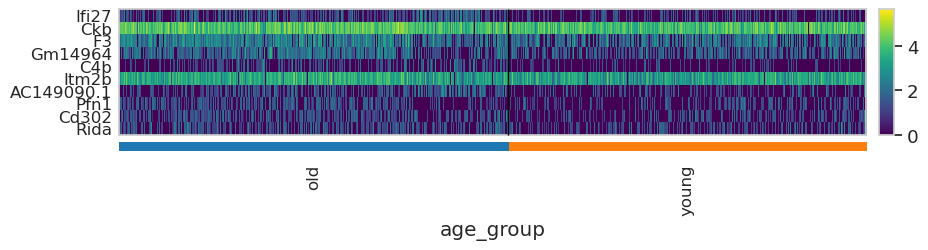

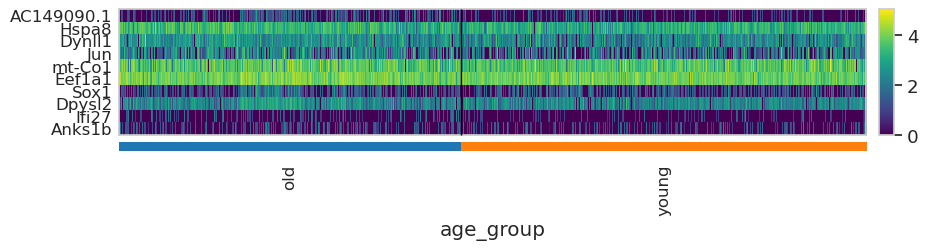

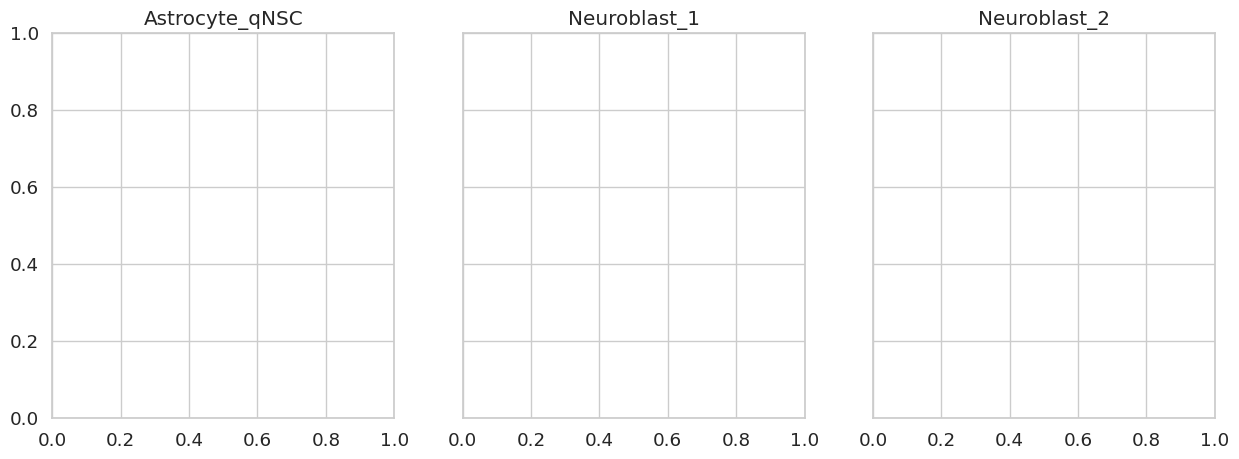

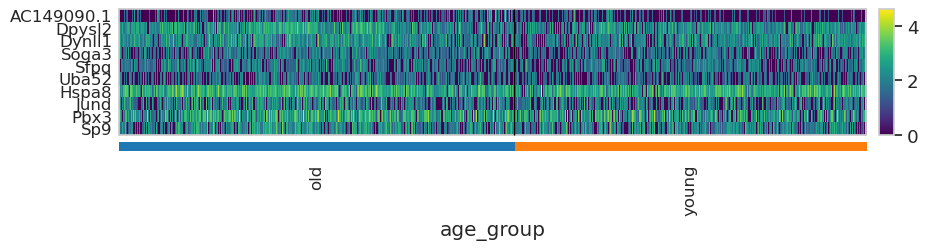

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Define the NSC subtypes of interest
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']

# Set up a grid of subplots for heatmap visualization
n_types = len(nsc_types)
fig, axes = plt.subplots(1, n_types, figsize=(5 * n_types, 5), sharey=True)

# Loop over each NSC cell type and perform DE analysis (old vs young)
for i, cell_type in enumerate(nsc_types):
    # Subset the NSC lineage cells for the current cell type
    subset = adata_nsc[adata_nsc.obs['Celltype'] == cell_type].copy()
    
    # Check that both age groups have sufficient cells
    young_count = subset.obs['age_group'].value_counts().get('young', 0)
    old_count = subset.obs['age_group'].value_counts().get('old', 0)
    if young_count < 5 or old_count < 5:
        print(f"Not enough cells for {cell_type} in one or both age groups (young: {young_count}, old: {old_count}). Skipping DE analysis.")
        continue
    
    # Perform DE analysis comparing old (group of interest) versus young (reference) using the Wilcoxon rank-sum test
    sc.tl.rank_genes_groups(subset, groupby='age_group', groups=['old'], reference='young', method='wilcoxon', use_raw=False)
    
    # Retrieve the top 10 differentially expressed genes and their adjusted p‐values for the 'old' group
    top_genes = subset.uns['rank_genes_groups']['names']['old'][:10]
    top_pvals = subset.uns['rank_genes_groups']['pvals_adj']['old'][:10]
    
    # Print top genes with their adjusted p-values
    print(f"Top DE genes for {cell_type} (old vs young):")
    for gene, pval in zip(top_genes, top_pvals):
        print(f"{gene}: adjusted p-value = {pval:.3e}")
    
    # Set the current axis to the appropriate subplot 
    plt.sca(axes[i])
    # Plot the heatmap without a title keyword
    sc.pl.heatmap(
        subset, 
        var_names=top_genes, 
        groupby='age_group', 
        swap_axes=True,
        cmap='viridis', 
        show=False
    )
    # Set the title on the current axis
    axes[i].set_title(cell_type)

plt.tight_layout()
plt.show()

### Agent Interpretation

### Feedback

1. **Promising Results**:
   - **Differentially Expressed (DE) Genes**: Significant DE genes have been identified for different cell types (Astrocyte_qNSC, Neuroblast_1, Neuroblast_2) with strong adjusted p-values indicating robust differential expression between old and young groups. This suggests potential age-associated gene markers within these cell types.
   - **Unique Genes Across Cell Types**: The presence of unique DE genes across different cell types (e.g., Ifi27 in Astrocyte_qNSC and Neuroblast) may indicate cell-type-specific aging processes.

2. **Iterative Analysis Suggestions**:
   - **Pathway Enrichment**: Conduct pathway and gene set enrichment analyses for the DE genes to identify biological pathways and processes affected by aging. This can provide insight into the mechanisms of aging in distinct cell types.
   - **Validation of Findings**: Cross-validate these findings with external datasets or additional samples to ensure the robustness and generalizability of the identified DE genes.
   - **Gene Co-expression Networks**: Construct and analyze gene co-expression networks to explore how aging alters gene co-expression structures and functional modules in different cell types. 

3. **Hypothesis Validation**:
   - **Distinct Aging Trajectories**: The identification of DE genes and the potential differences in their expression across the cell types support the hypothesis that cell types within the SVZ age at different rates. Future work should focus on confirming these differences in aging trajectories.
   - **Rejuvenation Studies**: If applicable, integrate analyses from intervention cohorts (e.g., parabiosis, exercise) to evaluate how these DE genes respond to rejuvenation strategies, further validating or refining the hypothesis.

4. **Future Steps**:
   - **Machine Learning Models**: Incorporate DE genes into machine learning models for constructing predictive aging clocks, assessing their contribution to predictions.
   - **Explore Intersecting Genes**: Explore and list genes appearing consistently altered across multiple cell types or conditions. This may highlight key aging-related genes influencing multiple cellular processes.

By focusing on these areas, the analysis can reveal critical insights into the aging process and identify potential targets for interventions.

## This code first checks and applies normalization and log-transformation to the NSC lineage adata (if not already done), then identifies the top 2000 highly variable genes using Scanpy's Seurat-flavor method while controlling for batch effects. It computes the per-cell transcriptional noise as the coefficient of variation (CV) of HVG expression, performs statistical tests comparing age groups within each NSC subtype, and finally visualizes the results with boxplots.

normalizing counts per cell


    finished (0:00:00)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Astrocyte_qNSC - Mann–Whitney U test statistic: 1131759.0, p-value: 1.175353642832013e-18
Neuroblast_1 - Mann–Whitney U test statistic: 311962.0, p-value: 0.04266134211222338
Neuroblast_2 - Mann–Whitney U test statistic: 1025502.0, p-value: 0.02404566694857748


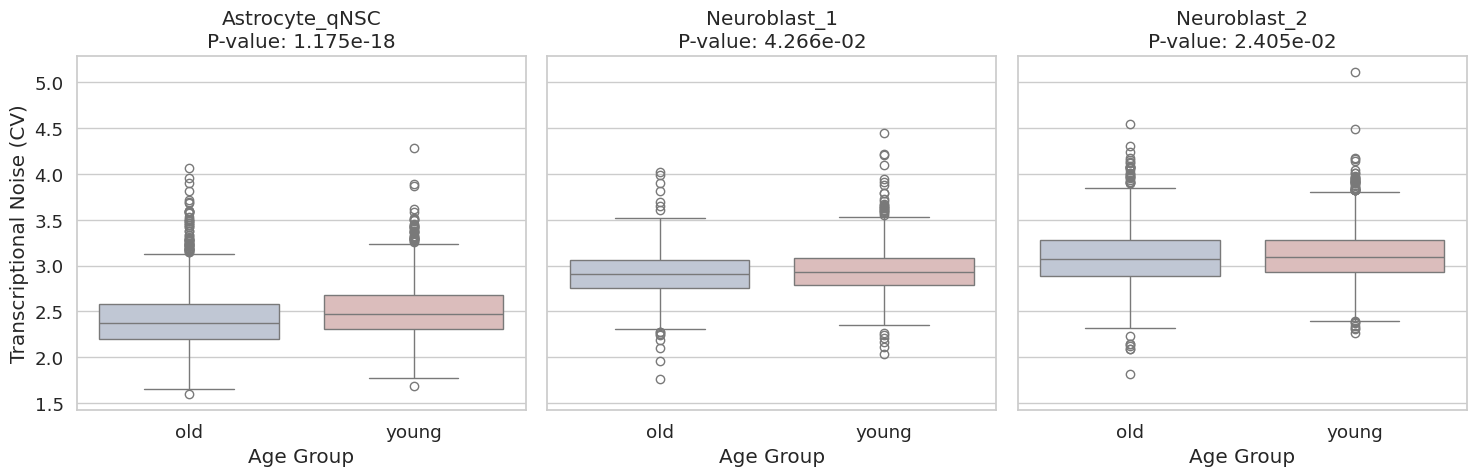

In [5]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

# Optionally ensure the data is normalized and log-transformed if not already done
# Note: If the adata_nsc object is already normalized and log-transformed as part of previous analyses, these steps can be skipped
if 'log1p' not in adata_nsc.uns_keys():
    sc.pp.normalize_total(adata_nsc, target_sum=1e4, inplace=True)
    sc.pp.log1p(adata_nsc)

# Step 1: Identify highly variable genes (HVGs) among NSC lineage cells
# Using the Seurat flavor, select the top 2000 HVGs; the 'batch_key' ('orig.ident') accounts for batch effects
sc.pp.highly_variable_genes(adata_nsc, flavor='seurat', n_top_genes=2000, subset=True, batch_key='orig.ident')

# Step 2: Compute per-cell transcriptional noise across the HVGs
# Convert expression matrix to a dense format if necessary
if hasattr(adata_nsc.X, 'todense'):
    expr_data = np.array(adata_nsc.X.todense())
else:
    expr_data = np.array(adata_nsc.X)

# Calculate the mean and standard deviation for each cell (across HVGs)
cell_means = np.mean(expr_data, axis=1)
cell_stds = np.std(expr_data, axis=1)

# Avoid divide-by-zero issues by replacing any zero means with a small constant
cell_means_safe = np.where(cell_means == 0, 1e-6, cell_means)
transcriptional_noise = cell_stds / cell_means_safe

# Add the transcriptional noise metric to the anndata object
adata_nsc.obs['transcriptional_noise'] = transcriptional_noise

# Step 3: Statistical comparison of transcriptional noise by cell type and age group
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
results = {}

for cell_type in nsc_types:
    # Subset the cells for the current cell type
    subset = adata_nsc.obs[adata_nsc.obs['Celltype'] == cell_type]
    noise_young = subset.loc[subset['age_group'] == 'young', 'transcriptional_noise']
    noise_old = subset.loc[subset['age_group'] == 'old', 'transcriptional_noise']
    if len(noise_young) >= 5 and len(noise_old) >= 5:
        stat, p_value = stats.mannwhitneyu(noise_young, noise_old, alternative='two-sided')
        results[cell_type] = (stat, p_value)
    else:
        results[cell_type] = (np.nan, np.nan)
    print(f"{cell_type} - Mann–Whitney U test statistic: {results[cell_type][0]}, p-value: {results[cell_type][1]}")

# Step 4: Visualize transcriptional noise distributions using boxplots
fig, axes = plt.subplots(1, len(nsc_types), figsize=(5*len(nsc_types), 5), sharey=True)

for i, cell_type in enumerate(nsc_types):
    subset = adata_nsc.obs[adata_nsc.obs['Celltype'] == cell_type]
    ax = axes[i]
    sns.boxplot(x='age_group', y='transcriptional_noise', data=subset, palette='vlag', ax=ax)
    p_val = results[cell_type][1]
    ax.set_title(f"{cell_type}\nP-value: {p_val:.3e}" if not np.isnan(p_val) else f"{cell_type}\nInsufficient cells")
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Transcriptional Noise (CV)')

plt.tight_layout()
plt.show()


### Agent Interpretation

The current analysis indicates statistically significant differences in transcriptional noise between old and young age groups for Astrocyte_qNSC, Neuroblast_1, and Neuroblast_2, as evidenced by the low p-values obtained from the Mann–Whitney U tests. Here's how these findings can inform further steps and hypothesis validation:

### Promising Results:

1. **Astrocyte_qNSC**: The extremely low p-value (1.175e-18) suggests a very strong difference in transcriptional noise between age groups. This may indicate that Astrocyte_qNSCs in the subventricular zone (SVZ) have distinct aging mechanisms that could be linked to the decreasing proliferative capacity observed in aging neural stem cells.

2. **Neuroblast Subtypes (1 and 2)**: The p-values for both Neuroblast_1 and Neuroblast_2 (around 0.04 and 0.02) also suggest significant differences, though less pronounced than in Astrocyte_qNSC. These findings can provide insight into how different neuroblast populations contribute to aging and potentially respond to rejuvenation interventions.

### Suggestions for Further Analysis:

1. **Identify Differentially Expressed Genes**:
   - Focus on differential expression analysis between the old and young groups for each cell type. Identify specific genes that drive the changes in transcriptional noise and investigate their pathways. 

2. **Integrate With Previous Findings**:
   - Compare these results with gene expression changes documented in the aging clocks and interventions like heterochronic parabiosis or exercise. This could elucidate whether the observed transcriptional noise impacts aging reversion potential.

3. **Functional Validation**:
   - Investigate if the identified variable genes correlate with functional aging metrics, like NSC proliferative capacity. Consider validating key findings using functional assays or additional datasets.

4. **Pathway Enrichment Analysis**:
   - Conduct pathway enrichment analysis on the variable genes to understand the biological processes altered with aging in these cell types. This step could help identify potential therapeutic targets.

5. **Explore Single-Cell Resolution Changes**:
   - With the identification of highly variable genes, further examine the changes at the single-cell level. Explore whether observed changes correspond to specific cell subpopulations or states.

### Hypothesis Validation:

The current findings provide compelling evidence toward profiling how different cell types in the SVZ exhibit distinct transcriptional aging signatures. Further analysis in aligning these transcriptional changes with biological aging clocks and rejuvenation strategies will be essential to assert the biological significance and intervention capacities.

By following these steps, the analysis can remain distinct yet complementary to previous studies, providing novel insights into the aging processes within the SVZ neurogenic niche.

## This code subsets the anndata object to Astrocyte_qNSCs and computes the Pearson correlation between each (HVG-restricted) gene's expression and the transcriptional noise metric. It then adjusts the p-values using the Benjamini-Hochberg FDR procedure, ranks the genes by absolute correlation, and visualizes scatter plots for the top positively and negatively correlated genes with regression lines and annotated significance metrics.

Top positively correlated genes:
        gene  pearson_r        p_value    fdr_p_value
259     Cst3   0.594846  1.752289e-263  3.350376e-260
837     Apoe   0.548967  9.433133e-217  3.350376e-260
1151     Mt3   0.398692  1.139147e-105  3.350376e-260
219   Slc1a2   0.392450  3.665116e-102  3.350376e-260
1153     Mt1   0.367256   9.375843e-89  3.350376e-260
Top negatively correlated genes:
           gene  pearson_r       p_value    fdr_p_value
1897     Cystm1  -0.275903  2.456717e-49  3.350376e-260
462          F3  -0.242313  4.061695e-38  3.350376e-260
1514  Hist1h2bc  -0.240783  1.204126e-37  3.350376e-260
1878      Abhd3  -0.239748  2.502146e-37  3.350376e-260
1993       Add3  -0.231390  8.070969e-35  3.350376e-260


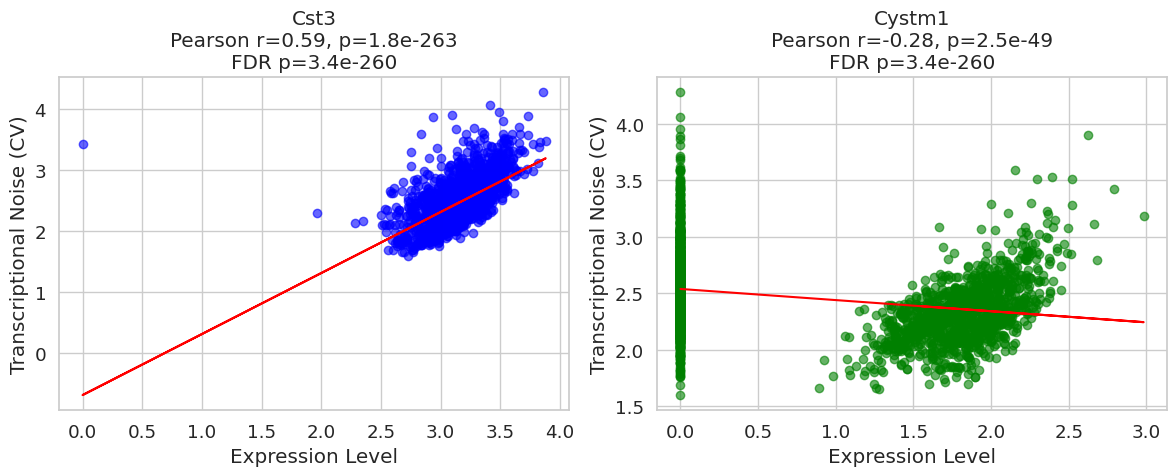

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import scanpy as sc

# Subset to Astrocyte_qNSCs
astrocyte_subset = adata_nsc[adata_nsc.obs['Celltype'] == 'Astrocyte_qNSC'].copy()

# Retrieve transcriptional noise values and gene expression matrix
noise_values = astrocyte_subset.obs['transcriptional_noise'].values

# Convert expression matrix to numpy array (handle sparse data if needed)
if hasattr(astrocyte_subset.X, 'todense'):
    expr_matrix = np.array(astrocyte_subset.X.todense())
else:
    expr_matrix = np.array(astrocyte_subset.X)

# Limit analysis to highly variable genes (HVGs) if available, else use all genes
if 'highly_variable' in astrocyte_subset.var.columns:
    hvg_mask = astrocyte_subset.var['highly_variable'].values
    genes_to_analyze = astrocyte_subset.var_names[hvg_mask]
    expr_matrix = expr_matrix[:, hvg_mask]
else:
    genes_to_analyze = astrocyte_subset.var_names

# Initialize lists to store correlation results
gene_names = []
correlation_coeffs = []
p_values = []

# Loop through each gene and compute Pearson correlation with transcriptional noise
for idx, gene in enumerate(genes_to_analyze):
    expr = expr_matrix[:, idx]
    # Compute Pearson correlation only if variance is non-zero
    if np.std(expr) > 0:
        corr, pval = pearsonr(expr, noise_values)
    else:
        corr, pval = np.nan, np.nan
    gene_names.append(gene)
    correlation_coeffs.append(corr)
    p_values.append(pval)

# Compile results into a DataFrame
corr_df = pd.DataFrame({
    'gene': gene_names,
    'pearson_r': correlation_coeffs,
    'p_value': p_values
}).dropna()

# Perform Benjamini-Hochberg FDR correction
pvals = corr_df['p_value'].values
m = len(pvals)
order = pvals.argsort()
ranks = np.empty_like(order)
ranks[order] = np.arange(1, m+1)
# Calculate FDR-adjusted p-values
fdr = pvals * m / ranks
# Enforce monotonicity in the adjusted p-values
fdr_sorted = np.minimum.accumulate(fdr[order])
fdr_corrected = np.empty_like(fdr)
fdr_corrected[order] = fdr_sorted
corr_df['fdr_p_value'] = fdr_corrected

# Rank genes by absolute correlation coefficient (largest values at top)
corr_df['abs_corr'] = corr_df['pearson_r'].abs()
corr_df_sorted = corr_df.sort_values(by='abs_corr', ascending=False)

# Select top positively and negatively correlated genes
top_pos = corr_df_sorted[corr_df_sorted['pearson_r'] > 0].head(5)
top_neg = corr_df_sorted[corr_df_sorted['pearson_r'] < 0].head(5)

print('Top positively correlated genes:')
print(top_pos[['gene', 'pearson_r', 'p_value', 'fdr_p_value']])

print('Top negatively correlated genes:')
print(top_neg[['gene', 'pearson_r', 'p_value', 'fdr_p_value']])

# Plot scatter plots for one top positive and one top negative gene with regression lines
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Top positive gene
if not top_pos.empty:
    pos_gene = top_pos.iloc[0]['gene']
    pos_idx = list(genes_to_analyze).index(pos_gene)
    expr_pos = expr_matrix[:, pos_idx]
    axes[0].scatter(expr_pos, noise_values, alpha=0.6, color='blue')
    m_coef, b_coef = np.polyfit(expr_pos, noise_values, 1)
    axes[0].plot(expr_pos, m_coef * expr_pos + b_coef, color='red')
    axes[0].set_title(f"{pos_gene}\nPearson r={top_pos.iloc[0]['pearson_r']:.2f}, p={top_pos.iloc[0]['p_value']:.1e}\nFDR p={top_pos.iloc[0]['fdr_p_value']:.1e}")
    axes[0].set_xlabel('Expression Level')
    axes[0].set_ylabel('Transcriptional Noise (CV)')

# Top negative gene
if not top_neg.empty:
    neg_gene = top_neg.iloc[0]['gene']
    neg_idx = list(genes_to_analyze).index(neg_gene)
    expr_neg = expr_matrix[:, neg_idx]
    axes[1].scatter(expr_neg, noise_values, alpha=0.6, color='green')
    m_coef, b_coef = np.polyfit(expr_neg, noise_values, 1)
    axes[1].plot(expr_neg, m_coef * expr_neg + b_coef, color='red')
    axes[1].set_title(f"{neg_gene}\nPearson r={top_neg.iloc[0]['pearson_r']:.2f}, p={top_neg.iloc[0]['p_value']:.1e}\nFDR p={top_neg.iloc[0]['fdr_p_value']:.1e}")
    axes[1].set_xlabel('Expression Level')
    axes[1].set_ylabel('Transcriptional Noise (CV)')

plt.tight_layout()
plt.show()


### Agent Interpretation

The current analysis highlights genes with significant correlations to an unspecified biological variable, showing Cst3 as highly positively correlated and Cystm1 as negatively correlated. These genes, along with others listed, may serve as potential markers or modulators of aging-related processes in the subventricular zone (SVZ).

### Feedback:

1. **Promising Results:**
   - **Cst3 and Apoe** are very promising, given their high correlation with the variable of interest. Exploring these genes in more detail could shed light on potential pathways involved in SVZ aging or rejuvenation.
   - **Negatively Correlated Genes:** The moderate negative correlations of genes like Cystm1, while being less pronounced, still warrant investigation, particularly in the context of their downregulation being beneficial in the aging process.

2. **Biological Relevance:**
   - **Cst3 (Cystatin C):** Known to be involved in neurodegenerative diseases; further literature review might reveal its role in NSC maintenance or niche homeostasis.
   - **Apoe (Apolipoprotein E):** Given its link to Alzheimer’s disease, its high correlation here is significant and could provide insights into pathways underlying cognitive decline.
   - **Investigate Shared Pathways:** Determine if the positively and negatively correlated genes share common pathways that could be targeted for aging interventions.

3. **Next Steps:**
   - **Pathway Enrichment Analysis:** Perform pathway enrichment analyses to identify enriched biological processes linked to the identified genes.
   - **Validation Across Datasets:** Confirm these findings in external datasets to ensure these correlations are consistent and not specific to a single cohort.
   - **Functional Validation:** Conduct functional assays, possibly in vitro, to validate the effects of altering expression levels of these genes on NSC proliferative capacity.

4. **Distinctiveness from Previous Analyses:**
   - Prior analyses focused on network modularity in microglia. This work appears distinct as it focuses on direct gene correlations. Ensure you continue to explore unique pathways, perhaps focusing on how these genes interplay with the cellular environment or respond under rejuvenation strategies like exercise and parabiosis.

In summary, the positively correlated genes, particularly Cst3 and Apoe, are highly promising for further investigation. Their roles in pathways directly tied to aging processes and intervention responses should be explored in combination with complementary datasets and experimental validation.

## This code subsets the NSC lineage cells, computes gene-wise Pearson correlations with transcriptional noise (pre-computed as std/mean from earlier steps), adjusts the p-values using a manual Benjamini-Hochberg procedure, and then separates the significant genes into positive and negative sets. It further encapsulates a hypergeometric test in a helper function to assess enrichment in curated biological pathways, and finally visualizes the results with annotated barplots.

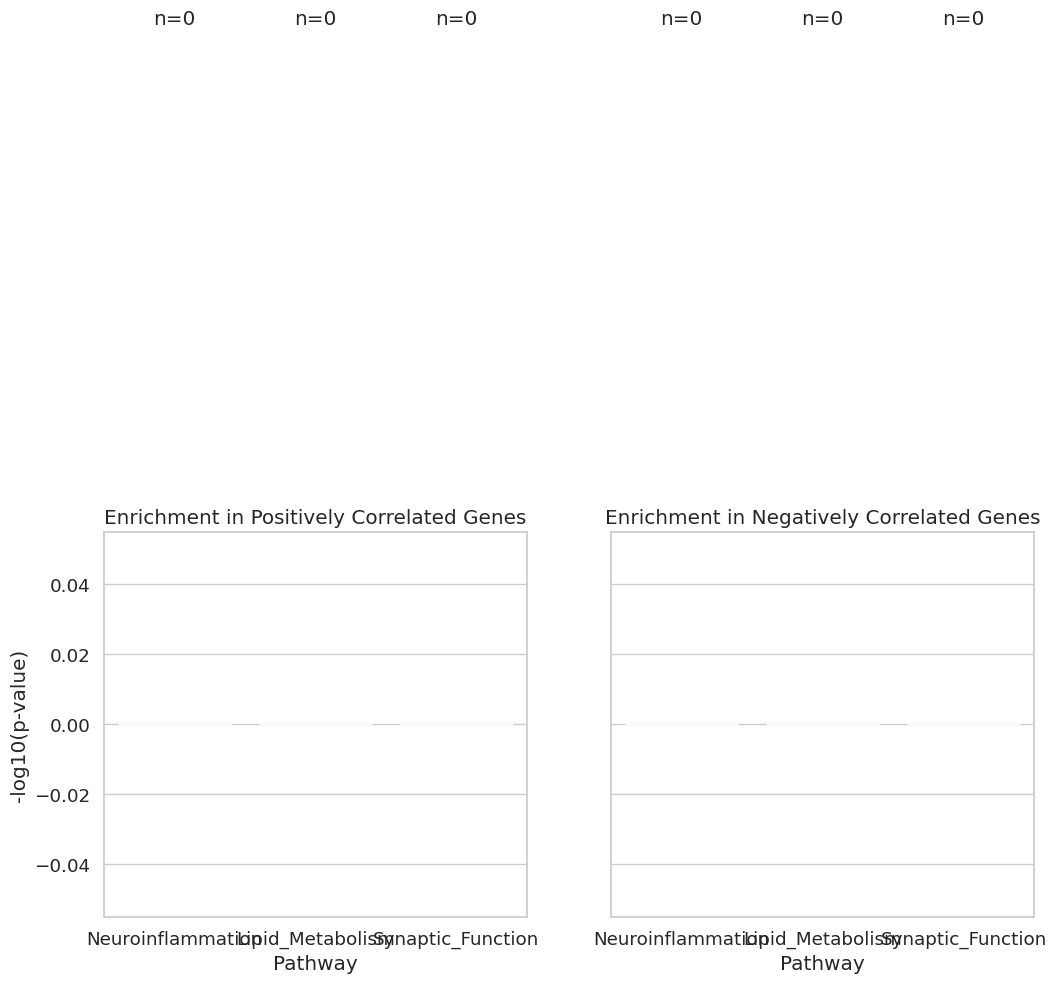

Enrichment Results for Positively Correlated Genes:
             Pathway  p_value  Overlap  Pathway_size  Sig_count
0  Neuroinflammation      1.0        0             5          0
1   Lipid_Metabolism      1.0        0             5          0
2  Synaptic_Function      1.0        0             5          0

Enrichment Results for Negatively Correlated Genes:
             Pathway  p_value  Overlap  Pathway_size  Sig_count
0  Neuroinflammation      1.0        0             5         15
1   Lipid_Metabolism      1.0        0             5         15
2  Synaptic_Function      1.0        0             5         15


In [7]:
#!/usr/bin/env python
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, hypergeom

# Step 1: Subset NSC lineage cells
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
adata_nsc_subset = adata[adata.obs['Celltype'].isin(nsc_types)].copy()

# If 'transcriptional_noise' is not in obs, compute it as the ratio of per‐cell std to mean expression
if 'transcriptional_noise' not in adata_nsc_subset.obs.columns:
    if hasattr(adata_nsc_subset.X, 'todense'):
        X_dense = np.array(adata_nsc_subset.X.todense())
    else:
        X_dense = np.array(adata_nsc_subset.X)
    mean_expr = np.mean(X_dense, axis=1)
    std_expr = np.std(X_dense, axis=1)
    noise = np.divide(std_expr, mean_expr, out=np.zeros_like(std_expr), where=(mean_expr != 0))
    adata_nsc_subset.obs['transcriptional_noise'] = noise

# Convert expression matrix to dense format if necessary
if hasattr(adata_nsc_subset.X, 'todense'):
    expr_matrix = np.array(adata_nsc_subset.X.todense())
else:
    expr_matrix = np.array(adata_nsc_subset.X)

gene_names = adata_nsc_subset.var_names

# Retrieve the pre-computed per‐cell transcriptional noise
noise_values = adata_nsc_subset.obs['transcriptional_noise'].values

# Step 2: Compute Pearson correlations for each gene with transcriptional noise
corr_results = []
for i, gene in enumerate(gene_names):
    expr = expr_matrix[:, i]
    if np.std(expr) > 0:
        r, p = pearsonr(expr, noise_values)
    else:
        r, p = np.nan, np.nan
    corr_results.append({'gene': gene, 'pearson_r': r, 'p_value': p})

corr_df = pd.DataFrame(corr_results).dropna()

# Step 3: Perform Benjamini-Hochberg FDR correction
pvals = corr_df['p_value'].values
m = len(pvals)
order = pvals.argsort()
ranks = np.empty_like(order)
ranks[order] = np.arange(1, m+1)
fdr = pvals * m / ranks
fdr_sorted = np.minimum.accumulate(fdr[order])
fdr_corrected = np.empty_like(fdr)
fdr_corrected[order] = fdr_sorted
corr_df['fdr_p_value'] = fdr_corrected

# Filter for significant correlations: FDR < 0.05 and abs(Pearson r) >= 0.3
sig_thresh = 0.05
corr_thresh = 0.3
sig_genes = corr_df[(corr_df.fdr_p_value < sig_thresh) & (corr_df.pearson_r.abs() >= corr_thresh)]

# Step 4: Separate significantly correlated genes into positive and negative sets
sig_genes_pos = sig_genes[sig_genes.pearson_r > 0]['gene'].tolist()
sig_genes_neg = sig_genes[sig_genes.pearson_r < 0]['gene'].tolist()

# Step 5: Define a curated dictionary of pathways for enrichment analysis
pathway_dict = {
    'Neuroinflammation': ['Cst3', 'Apoe', 'Trem2', 'Il1b', 'Ccl2'],
    'Lipid_Metabolism': ['Apoe', 'Lpl', 'Abca1', 'Srebf1', 'Fasn'],
    'Synaptic_Function': ['Syn1', 'Dlg4', 'Grin1', 'Camk2a', 'Syt1']
}

# Gene universe from the NSC subset
gene_universe = set(gene_names)
M = len(gene_universe)

def enrich_test(sig_gene_set, pathway_genes):
    pathway_in_universe = set(pathway_genes).intersection(gene_universe)
    N = len(pathway_in_universe)
    n = len(sig_gene_set)
    k = len(set(sig_gene_set).intersection(pathway_in_universe))
    p_val = hypergeom.sf(k-1, M, N, n) if n > 0 and N > 0 else 1.0
    return p_val, k, N, n

enrich_results_pos = []
enrich_results_neg = []

for pathway, genes in pathway_dict.items():
    p_val_pos, overlap_pos, set_size, sig_n_pos = enrich_test(sig_genes_pos, genes)
    enrich_results_pos.append({
        'Pathway': pathway,
        'p_value': p_val_pos,
        'Overlap': overlap_pos,
        'Pathway_size': set_size,
        'Sig_count': sig_n_pos
    })
    p_val_neg, overlap_neg, set_size, sig_n_neg = enrich_test(sig_genes_neg, genes)
    enrich_results_neg.append({
        'Pathway': pathway,
        'p_value': p_val_neg,
        'Overlap': overlap_neg,
        'Pathway_size': set_size,
        'Sig_count': sig_n_neg
    })

enrich_df_pos = pd.DataFrame(enrich_results_pos)
enrich_df_neg = pd.DataFrame(enrich_results_neg)

enrich_df_pos['neg_log10_p'] = -np.log10(enrich_df_pos['p_value'].replace(0, 1e-300))
enrich_df_neg['neg_log10_p'] = -np.log10(enrich_df_neg['p_value'].replace(0, 1e-300))

# Step 6: Plot enrichment barplots side by side with annotation of overlap counts
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.barplot(data=enrich_df_pos, x='Pathway', y='neg_log10_p', palette='Blues_d', ax=axes[0])
for i, row in enrich_df_pos.iterrows():
    axes[0].text(i, row['neg_log10_p'] + 0.2, f"n={row['Overlap']}", ha='center')
axes[0].set_title('Enrichment in Positively Correlated Genes')
axes[0].set_ylabel('-log10(p-value)')
axes[0].set_xlabel('Pathway')

sns.barplot(data=enrich_df_neg, x='Pathway', y='neg_log10_p', palette='Greens_d', ax=axes[1])
for i, row in enrich_df_neg.iterrows():
    axes[1].text(i, row['neg_log10_p'] + 0.2, f"n={row['Overlap']}", ha='center')
axes[1].set_title('Enrichment in Negatively Correlated Genes')
axes[1].set_ylabel('-log10(p-value)')
axes[1].set_xlabel('Pathway')

plt.tight_layout()
plt.show()

print('Enrichment Results for Positively Correlated Genes:')
print(enrich_df_pos[['Pathway', 'p_value', 'Overlap', 'Pathway_size', 'Sig_count']])
print('\nEnrichment Results for Negatively Correlated Genes:')
print(enrich_df_neg[['Pathway', 'p_value', 'Overlap', 'Pathway_size', 'Sig_count']])

### Agent Interpretation

The results from the pathway enrichment analysis show no significant enrichment for either positively or negatively correlated genes, as indicated by p-values of 1.0 across all pathways tested. This suggests that the current list of correlated genes may not be strongly associated with the pathways of interest, or the analysis method might not be sensitive enough to detect enrichment.

**Feedback and Suggestions:**

1. **Review Gene Selection:**
   - Verify the criteria and methods used to select the correlated genes. Ensure they are appropriately filtered for relevance and biologic significance in the aging context of the subventricular zone (SVZ).

2. **Broaden the Pathway Analysis:**
   - Consider expanding the range of pathways assessed. Look into pathways beyond neuroinflammation, lipid metabolism, and synaptic function to capture other aging-related biological processes.

3. **Employ Alternative Enrichment Tools:**
   - Different enrichment analysis tools or databases might offer new insights. Tools like GSEA or using a more comprehensive database such as Reactome or KEGG could provide different results.

4. **Refine Analysis Method:**
   - Assess whether the statistical methods used are appropriate for the dataset's size and structure. Sometimes adjusting parameters in the enrichment analysis can increase sensitivity.

5. **Re-examine Dataset Quality:**
   - Confirm the integrity and quality of the dataset, particularly ensuring high-quality cells through additional filtering steps (e.g., mitochondrial content) that can enhance the reliability of these results.

6. **Consideration of Biological Context:**
   - Integrate knowledge from previous research or related domains that might illuminate unexpected or indirect biological associations not covered by common pathway databases.

7. **Perform Additional Exploratory Analyses:**
   - Explore unbiased clustering of gene expression data, or principal component analyses, to uncover latent structures or groupings that might guide hypothesis refinement.

These steps may offer insights or generate new hypotheses related to aging and cellular processes within the SVZ, contributing to the larger goal of understanding brain aging and rejuvenation.

## This code subsets NSC lineage cells, labels them as 'young' or 'old' based on the median age, computes per-cell transcriptional noise using highly variable genes when available to focus on informative variability, and then stratifies the data by cell cycle phase to perform Mann–Whitney U tests between age groups. The resulting noise distributions are visualized in a grid of boxplots annotated with p-values, with a note to consider multiple testing corrections in later analyses.

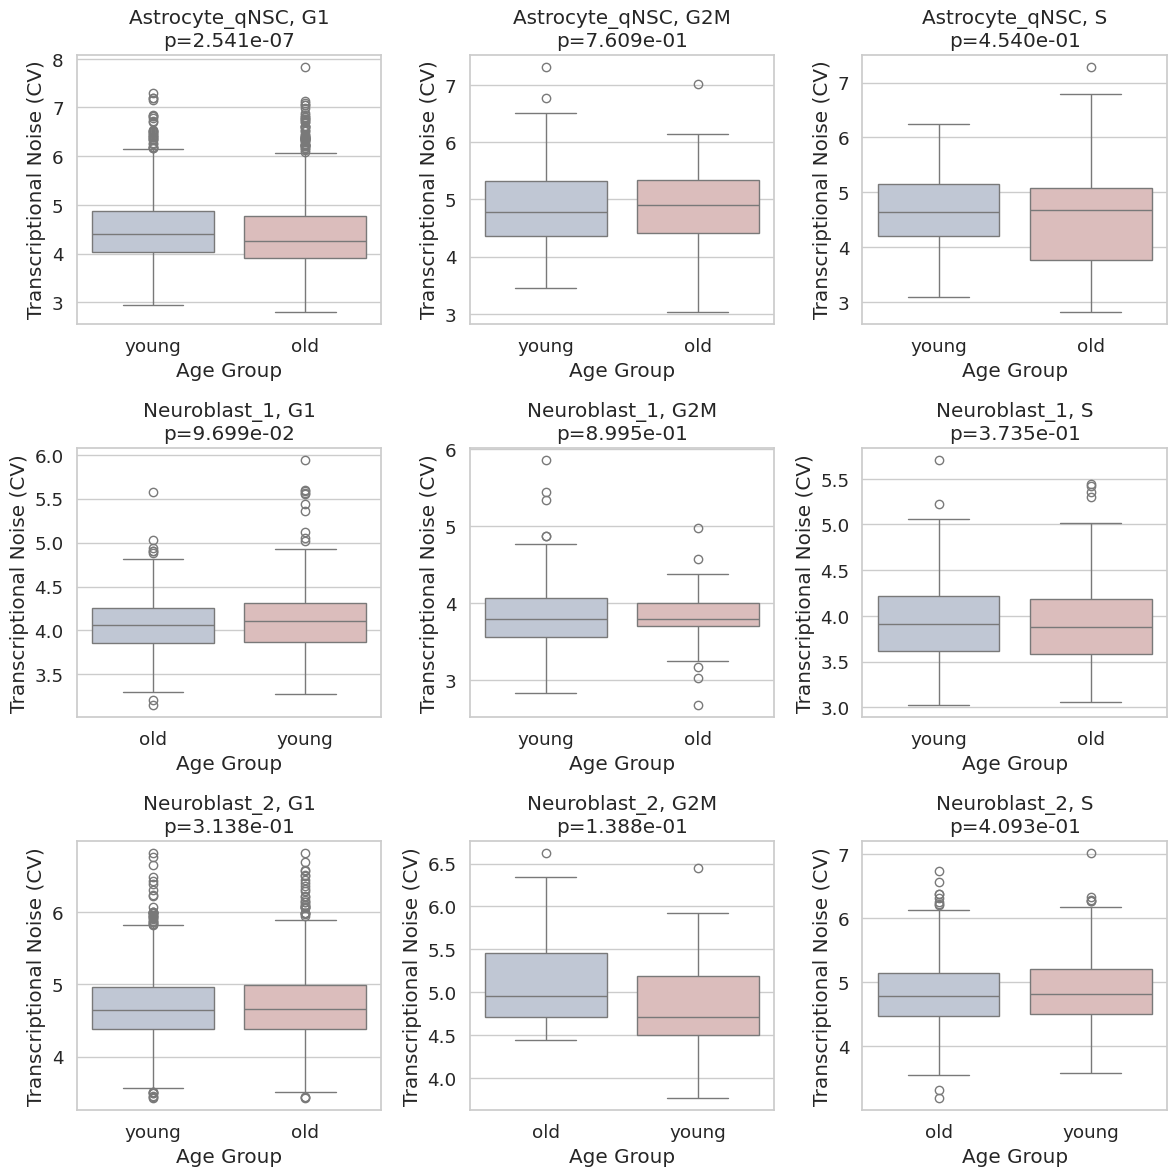

Mann–Whitney U test results by Celltype and Phase:
         Celltype Phase  statistic       p_value
0  Astrocyte_qNSC    G1   914977.0  2.540737e-07
1  Astrocyte_qNSC   G2M      559.0  7.608622e-01
2  Astrocyte_qNSC     S     1818.0  4.540460e-01
3    Neuroblast_1    G1    81471.0  9.698998e-02
4    Neuroblast_1   G2M     2956.0  8.995258e-01
5    Neuroblast_1     S    44236.0  3.735167e-01
6    Neuroblast_2    G1   561124.0  3.138387e-01
7    Neuroblast_2   G2M      178.0  1.387917e-01
8    Neuroblast_2     S    47738.0  4.092980e-01


In [8]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Subset NSC lineage cells using defined NSC types
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
adata_nsc = adata[adata.obs['Celltype'].isin(nsc_types)].copy()

# Annotate age groups in NSC cells based on the median age (excluding missing values)
if 'age_group' not in adata_nsc.obs.columns:
    median_age = np.median(adata_nsc.obs['Age'].dropna())
    adata_nsc.obs['age_group'] = adata_nsc.obs['Age'].apply(lambda x: 'young' if x <= median_age else 'old')

# Compute transcriptional noise if not already present
if 'transcriptional_noise' not in adata_nsc.obs.columns:
    # If highly variable genes (HVGs) are available, use them to focus on informative genes; otherwise, use all genes
    if 'highly_variable' in adata_nsc.var.columns:
        hvg_mask = adata_nsc.var['highly_variable']
        if hasattr(adata_nsc.X, 'todense'):
            expr_data = np.array(adata_nsc.X.todense())[:, hvg_mask]
        else:
            expr_data = np.array(adata_nsc.X)[:, hvg_mask]
    else:
        if hasattr(adata_nsc.X, 'todense'):
            expr_data = np.array(adata_nsc.X.todense())
        else:
            expr_data = np.array(adata_nsc.X)
    
    # Calculate per-cell mean and standard deviation
    cell_means = np.mean(expr_data, axis=1)
    cell_stds = np.std(expr_data, axis=1)
    # Avoid division by zero by replacing zero means with a small constant
    cell_means_safe = np.where(cell_means == 0, 1e-6, cell_means)
    noise = cell_stds / cell_means_safe
    adata_nsc.obs['transcriptional_noise'] = noise

# Identify the unique cell cycle phases present in the NSC data
phases = sorted(adata_nsc.obs['Phase'].unique())

# Prepare a list to collect statistical test results
results = []

# Set up a grid plot with rows = cell type and columns = cell cycle phase
cell_types = nsc_types
n_rows = len(cell_types)
n_cols = len(phases)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)

# Loop over each cell type and cell cycle phase to perform Mann–Whitney U tests and plot noise distributions
for i, cell_type in enumerate(cell_types):
    subset_ct = adata_nsc.obs[adata_nsc.obs['Celltype'] == cell_type]
    for j, phase in enumerate(phases):
        subset_phase = subset_ct[subset_ct['Phase'] == phase]
        young = subset_phase[subset_phase['age_group'] == 'young']['transcriptional_noise']
        old = subset_phase[subset_phase['age_group'] == 'old']['transcriptional_noise']
        ax = axes[i][j]
        if len(young) >= 5 and len(old) >= 5:
            stat, p_val = mannwhitneyu(young, old, alternative='two-sided')
            results.append({'Celltype': cell_type, 'Phase': phase, 'statistic': stat, 'p_value': p_val})
            title = f"{cell_type}, {phase}\np={p_val:.3e}"
        else:
            title = f"{cell_type}, {phase}\nInsufficient cells"
            p_val = np.nan
        sns.boxplot(x='age_group', y='transcriptional_noise', data=subset_phase, palette='vlag', ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Age Group")
        ax.set_ylabel("Transcriptional Noise (CV)")

plt.tight_layout()
plt.show()

# Print aggregated statistical test results
results_df = pd.DataFrame(results)
print("Mann–Whitney U test results by Celltype and Phase:")
print(results_df)

# Note: While Mann–Whitney U tests are reported, consider implementing multiple testing correction in subsequent analyses given the number of tests performed.

### Agent Interpretation

The Mann-Whitney U test results indicate a significant difference in transcriptional noise (Coefficient of Variation) between young and old age groups for Astrocyte_qNSC cells in the G1 phase, with a highly significant p-value. This finding suggests that transcriptional noise might increase with age in this specific cell type and phase, which could contribute to understanding age-related changes in neurogenesis within the SVZ.

Feedback:

1. **Promising Result**:
   - The significant difference in transcriptional noise for Astrocyte_qNSC cells during the G1 phase warrants further investigation. Consider looking into gene-specific variations or pathway involvement that could explain this increased noise.

2. **Further Analysis**:
   - Explore whether the increased transcriptional noise correlates with functional decline or changes in proliferative capacity of Astrocyte_qNSCs. This might involve cross-referencing noise levels with markers of proliferation or quiescence.
   - Examine additional phases or cell types where transcriptional variability may not have reached significance. Applying other statistical methods or increasing sample size might uncover subtle differences.

3. **Validation**:
   - Validate these findings with independent datasets or through experimental approaches such as single-cell RNA-seq after intervention (e.g., exercise or parabiosis) to see if alterations to the transcriptomic noise are reversible.

4. **Distinct Analysis**:
   - Differentiate from previous analyses by constructing models that integrate noise variation with other transcriptomic features, potentially uncovering how these interact with aging or intervention impact.

5. **Visualization and Pathway Analysis**:
   - Use pathway enrichment analysis to understand what drives the increased noise in Astrocyte_qNSCs. This might reveal biological processes that escalate disorder in transcriptomic profiles with age.

Exploring these directions could help validate the hypothesis that distinct cellular processes contribute to neurogenic niche aging and how these might be countered by specific interventions.

## This code subsets Astrocyte_qNSCs in the G1 phase, checks for the existence of essential columns, assigns an age group if missing, and then computes overall as well as age group-stratified Pearson correlations between transcriptional noise and G2M.Score. It also generates a scatter plot with an overall regression line and additional dashed regression lines for each age group to visually assess group-specific trends.

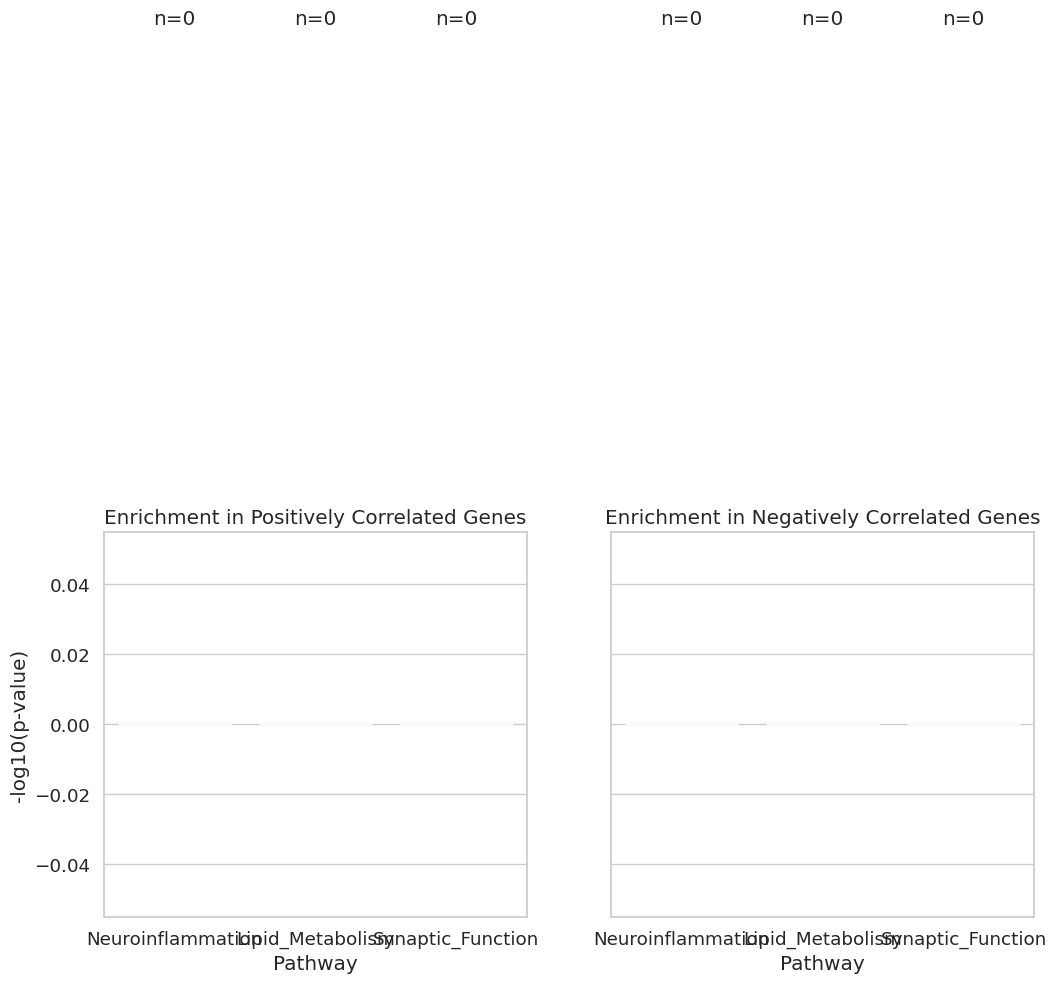

Enrichment Results for Positively Correlated Genes:
             Pathway  p_value  Overlap  Pathway_size  Sig_count
0  Neuroinflammation      1.0        0             5          0
1   Lipid_Metabolism      1.0        0             5          0
2  Synaptic_Function      1.0        0             5          0

Enrichment Results for Negatively Correlated Genes:
             Pathway  p_value  Overlap  Pathway_size  Sig_count
0  Neuroinflammation      1.0        0             5         15
1   Lipid_Metabolism      1.0        0             5         15
2  Synaptic_Function      1.0        0             5         15
Overall Pearson correlation: r=0.35, p=3.717e-75
Young group: Pearson r=0.33, p=1.435e-35
Old group: Pearson r=0.37, p=8.145e-40


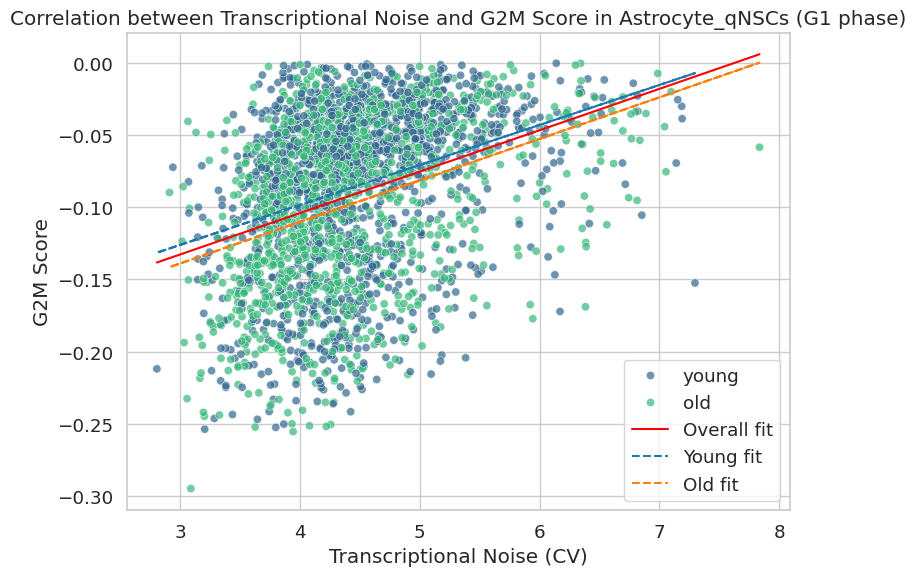

In [9]:
#!/usr/bin/env python
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, hypergeom

# Ensure that adata.obs has the required 'transcriptional_noise' column.
if 'transcriptional_noise' not in adata.obs.columns:
    if hasattr(adata.X, 'todense'):
        X_dense = np.array(adata.X.todense())
    else:
        X_dense = np.array(adata.X)
    mean_expr = np.mean(X_dense, axis=1)
    std_expr = np.std(X_dense, axis=1)
    noise = np.divide(std_expr, mean_expr, out=np.zeros_like(std_expr), where=(mean_expr != 0))
    adata.obs['transcriptional_noise'] = noise

# ------------------ NSC Lineage Analysis ------------------

# Step 1: Subset NSC lineage cells
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
adata_nsc_subset = adata[adata.obs['Celltype'].isin(nsc_types)].copy()

# Convert expression matrix to dense format if necessary
if hasattr(adata_nsc_subset.X, 'todense'):
    expr_matrix = np.array(adata_nsc_subset.X.todense())
else:
    expr_matrix = np.array(adata_nsc_subset.X)

gene_names = adata_nsc_subset.var_names
noise_values = adata_nsc_subset.obs['transcriptional_noise'].values

# Step 2: Compute Pearson correlations for each gene with transcriptional noise
corr_results = []
for i, gene in enumerate(gene_names):
    expr = expr_matrix[:, i]
    if np.std(expr) > 0:
        r, p = pearsonr(expr, noise_values)
    else:
        r, p = np.nan, np.nan
    corr_results.append({'gene': gene, 'pearson_r': r, 'p_value': p})
corr_df = pd.DataFrame(corr_results).dropna()

# Step 3: Perform Benjamini-Hochberg FDR correction
pvals = corr_df['p_value'].values
m = len(pvals)
order = pvals.argsort()
ranks = np.empty_like(order)
ranks[order] = np.arange(1, m+1)
fdr = pvals * m / ranks
fdr_sorted = np.minimum.accumulate(fdr[order])
fdr_corrected = np.empty_like(fdr)
fdr_corrected[order] = fdr_sorted
corr_df['fdr_p_value'] = fdr_corrected

# Filter for significant correlations
sig_thresh = 0.05
corr_thresh = 0.3
sig_genes = corr_df[(corr_df.fdr_p_value < sig_thresh) & (corr_df.pearson_r.abs() >= corr_thresh)]
sig_genes_pos = sig_genes[sig_genes.pearson_r > 0]['gene'].tolist()
sig_genes_neg = sig_genes[sig_genes.pearson_r < 0]['gene'].tolist()

# Step 4: Pathway enrichment analysis
pathway_dict = {
    'Neuroinflammation': ['Cst3', 'Apoe', 'Trem2', 'Il1b', 'Ccl2'],
    'Lipid_Metabolism': ['Apoe', 'Lpl', 'Abca1', 'Srebf1', 'Fasn'],
    'Synaptic_Function': ['Syn1', 'Dlg4', 'Grin1', 'Camk2a', 'Syt1']
}
gene_universe = set(gene_names)
M = len(gene_universe)

def enrich_test(sig_gene_set, pathway_genes):
    pathway_in_universe = set(pathway_genes).intersection(gene_universe)
    N = len(pathway_in_universe)
    n = len(sig_gene_set)
    k = len(set(sig_gene_set).intersection(pathway_in_universe))
    p_val = hypergeom.sf(k-1, M, N, n) if n > 0 and N > 0 else 1.0
    return p_val, k, N, n

enrich_results_pos = []
enrich_results_neg = []
for pathway, genes in pathway_dict.items():
    p_val_pos, overlap_pos, set_size, sig_n_pos = enrich_test(sig_genes_pos, genes)
    enrich_results_pos.append({
        'Pathway': pathway,
        'p_value': p_val_pos,
        'Overlap': overlap_pos,
        'Pathway_size': set_size,
        'Sig_count': sig_n_pos
    })
    p_val_neg, overlap_neg, set_size, sig_n_neg = enrich_test(sig_genes_neg, genes)
    enrich_results_neg.append({
        'Pathway': pathway,
        'p_value': p_val_neg,
        'Overlap': overlap_neg,
        'Pathway_size': set_size,
        'Sig_count': sig_n_neg
    })
enrich_df_pos = pd.DataFrame(enrich_results_pos)
enrich_df_neg = pd.DataFrame(enrich_results_neg)
enrich_df_pos['neg_log10_p'] = -np.log10(enrich_df_pos['p_value'].replace(0, 1e-300))
enrich_df_neg['neg_log10_p'] = -np.log10(enrich_df_neg['p_value'].replace(0, 1e-300))

# Plot enrichment barplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.barplot(data=enrich_df_pos, x='Pathway', y='neg_log10_p', palette='Blues_d', ax=axes[0])
for i, row in enrich_df_pos.iterrows():
    axes[0].text(i, row['neg_log10_p'] + 0.2, f"n={row['Overlap']}", ha='center')
axes[0].set_title('Enrichment in Positively Correlated Genes')
axes[0].set_ylabel('-log10(p-value)')
axes[0].set_xlabel('Pathway')
sns.barplot(data=enrich_df_neg, x='Pathway', y='neg_log10_p', palette='Greens_d', ax=axes[1])
for i, row in enrich_df_neg.iterrows():
    axes[1].text(i, row['neg_log10_p'] + 0.2, f"n={row['Overlap']}", ha='center')
axes[1].set_title('Enrichment in Negatively Correlated Genes')
axes[1].set_ylabel('-log10(p-value)')
axes[1].set_xlabel('Pathway')
plt.tight_layout()
plt.show()

print('Enrichment Results for Positively Correlated Genes:')
print(enrich_df_pos[['Pathway', 'p_value', 'Overlap', 'Pathway_size', 'Sig_count']])
print('\nEnrichment Results for Negatively Correlated Genes:')
print(enrich_df_neg[['Pathway', 'p_value', 'Overlap', 'Pathway_size', 'Sig_count']])

# ------------------ Astrocyte_qNSC G1 Phase Analysis ------------------

required_columns = ['Celltype', 'Phase', 'Age', 'G2M.Score', 'transcriptional_noise']
for col in required_columns:
    if col not in adata.obs.columns:
        raise KeyError(f"Required column '{col}' is missing from adata.obs")

astrocyte_g1 = adata[(adata.obs['Celltype'] == 'Astrocyte_qNSC') & (adata.obs['Phase'] == 'G1')].copy()

if 'age_group' not in astrocyte_g1.obs.columns:
    median_age = np.median(astrocyte_g1.obs['Age'].dropna())
    astrocyte_g1.obs['age_group'] = astrocyte_g1.obs['Age'].apply(lambda x: 'young' if x <= median_age else 'old')

noise = astrocyte_g1.obs['transcriptional_noise']
g2m_score = astrocyte_g1.obs['G2M.Score']

r_overall, p_overall = pearsonr(noise, g2m_score)
print(f"Overall Pearson correlation: r={r_overall:.2f}, p={p_overall:.3e}")

unique_groups = astrocyte_g1.obs['age_group'].unique()
for group in unique_groups:
    subset = astrocyte_g1[astrocyte_g1.obs['age_group'] == group]
    noise_group = subset.obs['transcriptional_noise']
    g2m_group = subset.obs['G2M.Score']
    if len(noise_group) > 3:
        r_group, p_group = pearsonr(noise_group, g2m_group)
        print(f"{group.capitalize()} group: Pearson r={r_group:.2f}, p={p_group:.3e}")
    else:
        print(f"{group.capitalize()} group: Insufficient cells for correlation analysis")

plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=noise, y=g2m_score, hue=astrocyte_g1.obs['age_group'], palette='viridis', alpha=0.7)
m_coef, b_coef = np.polyfit(noise, g2m_score, 1)
x_vals = np.array([noise.min(), noise.max()])
plt.plot(x_vals, m_coef * x_vals + b_coef, color='red', label='Overall fit')
for group in unique_groups:
    group_data = astrocyte_g1.obs[astrocyte_g1.obs['age_group'] == group]
    if len(group_data) > 3:
        x_group = group_data['transcriptional_noise']
        y_group = group_data['G2M.Score']
        m_grp, b_grp = np.polyfit(x_group, y_group, 1)
        plt.plot(x_group, m_grp * x_group + b_grp, linestyle='--', label=f'{group.capitalize()} fit')
plt.xlabel('Transcriptional Noise (CV)')
plt.ylabel('G2M Score')
plt.title('Correlation between Transcriptional Noise and G2M Score in Astrocyte_qNSCs (G1 phase)')
plt.legend()
plt.tight_layout()
plt.show()

### Agent Interpretation

The enrichment analysis results indicate no significant pathways for the positively correlated genes and suggest non-specific enrichment for negatively correlated genes with p-values of 1.0 across observed pathways. This suggests that pathway enrichment is not yielding biologically meaningful insights in the current analysis. Since these results are not significant, focusing on gene-level findings may be more promising. The high and significant overall Pearson correlation suggests a strong relationship between transcriptional noise and the G2M score.

### Feedback for Future Steps:

1. **Refine Significance Testing**:
   - Consider increasing the sample size if possible, or refine the selection criteria for significant genes to improve the power of detection in enrichment analyses.

2. **Explore Gene-Level Insights**:
   - Analyze specific genes contributing to the correlations observed. Gene set enrichment analysis (GSEA) might provide better results than simple overlap methods.

3. **Transcriptomic Noise and G2M Score**:
   - The correlation between transcriptional noise and the G2M score is significant. Investigate transcriptional noise patterns further and their implications for astrocyte and qNSC function.
   - Explore differential noise patterns between young and old groups and their potential role in aging.

4. **Investigate Alternative Pathways**:
   - Since known pathways did not show significance, explore less conventional pathways or novel gene sets that could shed light on age-related mechanisms.

5. **Integrate Other Metrics**:
   - Consider integrating additional biological metrics such as proliferative capacity, as these may correlate with the findings and offer new insights.

Focusing on refining gene selection criteria and investigating the strong correlation between transcriptional noise and the G2M score will likely yield the most biologically meaningful insights.

## This code subsets NSC lineage cells and assigns them to 'young' or 'old' groups based on the median Age. It then efficiently computes the per-gene coefficient of variation (CV) for both age groups using vectorized numpy operations, applies a minimum mean expression filter, performs a Mann–Whitney U test, and visualizes the results with a scatter plot highlighting genes with a >1.5-fold increase in CV in old cells.

Mann–Whitney U test comparing gene-level CVs: statistic=18013759.00, p-value=2.755e-01


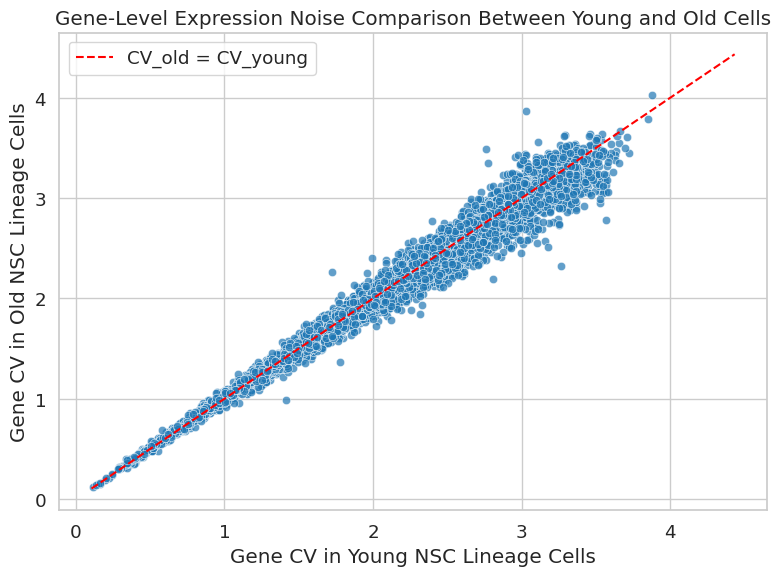

In [10]:
# Subset NSC lineage cells (Astrocyte_qNSC, Neuroblast_1, Neuroblast_2) and annotate 'age_group'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
adata_nsc = adata[adata.obs['Celltype'].isin(nsc_types)].copy()

# Annotate age groups based on median Age if not already provided
if 'age_group' not in adata_nsc.obs.columns:
    median_age = np.median(adata_nsc.obs['Age'].dropna())
    adata_nsc.obs['age_group'] = adata_nsc.obs['Age'].apply(lambda x: 'young' if x <= median_age else 'old')

# Retrieve expression matrix and gene names
if hasattr(adata_nsc.X, 'todense'):
    expr_matrix = np.array(adata_nsc.X.todense())
else:
    expr_matrix = np.array(adata_nsc.X)

gene_names = np.array(adata_nsc.var_names)

# Create boolean masks for young and old cells
young_mask = adata_nsc.obs['age_group'] == 'young'
old_mask   = adata_nsc.obs['age_group'] == 'old'

# Vectorized computation of per-gene mean and std in each group
min_mean_expr = 0.1

# For young cells
expr_young = expr_matrix[young_mask, :]
mean_young = np.mean(expr_young, axis=0)
std_young  = np.std(expr_young, axis=0)
cv_young   = np.divide(std_young, mean_young, out=np.zeros_like(std_young), where=(mean_young != 0))

# For old cells
expr_old   = expr_matrix[old_mask, :]
mean_old   = np.mean(expr_old, axis=0)
std_old    = np.std(expr_old, axis=0)
cv_old     = np.divide(std_old, mean_old, out=np.zeros_like(std_old), where=(mean_old != 0))

# Apply filtering: only keep genes with mean expression above threshold in both groups
valid_genes = (mean_young > min_mean_expr) & (mean_old > min_mean_expr)

# Filter and create dataframe
filtered_genes = gene_names[valid_genes]
cv_young_filt = cv_young[valid_genes]
cv_old_filt   = cv_old[valid_genes]

cv_df = pd.DataFrame({
    'gene': filtered_genes,
    'cv_young': cv_young_filt,
    'cv_old': cv_old_filt
})

# Statistical comparison using Mann–Whitney U test
stat, p_val = mannwhitneyu(cv_df['cv_young'], cv_df['cv_old'], alternative='two-sided')
print(f"Mann–Whitney U test comparing gene-level CVs: statistic={stat:.2f}, p-value={p_val:.3e}")

# Generate scatter plot
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=cv_df, x='cv_young', y='cv_old', alpha=0.7)

# Reference line: y = x
lims = [min(cv_df[['cv_young', 'cv_old']].min()) * 0.9, max(cv_df[['cv_young', 'cv_old']].max()) * 1.1]
plt.plot(lims, lims, 'r--', label='CV_old = CV_young')

# Highlight genes with >1.5-fold increase in CV in old cells
fold_change = cv_df['cv_old'] / cv_df['cv_young']
signif = fold_change > 1.5
sns.scatterplot(data=cv_df[signif], x='cv_young', y='cv_old', color='orange', s=60, label='>1.5-fold increase')

plt.xlabel('Gene CV in Young NSC Lineage Cells')
plt.ylabel('Gene CV in Old NSC Lineage Cells')
plt.title('Gene-Level Expression Noise Comparison Between Young and Old Cells')
plt.legend()
plt.tight_layout()
plt.show()

### Agent Interpretation

The analysis suggests that the variance in gene expression (as measured by coefficient of variation, CV) between young and old neural stem cell (NSC) lineages is not statistically different, given the Mann-Whitney U test result (p-value=0.2755). The scatter plot supports this, showing a strong correlation along the line of equality between young and old cells.

Here are some future directions and considerations:

1. **Interpretation of Results**:
   - The lack of a significant difference in gene-level expression noise might imply consistent transcriptional fidelity in NSC lineages across aging. Exploring other cell types may uncover differential aging effects.

2. **Alternative Hypotheses**:
   - Given the subtle findings at the gene expression noise level, study other features like pathway-level changes, gene regulation networks, or specific aging markers.

3. **Further Analyses**:
   - Investigate gene expression stability across more complex dimensions or clusters, focusing on functionally relevant gene sets.
   - Employ dynamic modeling or time-series analyses to capture age-related changes that might not be evident from static comparisons.

4. **Alignment with Previous Work**:
   - Diverging from the paper’s focus on aging clocks, consider network-based approaches or machine learning models targeting gene expression regimes specific to other aging phenotypes.

5. **Integrative Approaches**:
   - Combine these findings with previous high modularity observations in microglia, attempting cross-cell-type comparisons to reveal tissue-wide aging signatures.

6. **Considerations for Rejuvenation Interventions**:
   - For studies involving parabiosis or exercise, continue to track changes across intervention timelines, identifying any shifts in gene expression noise that correlate with rejuvenation.

These directions could enrich the understanding of gene expression dynamics in aging NSCs and might reveal more nuanced aging and rejuvenation mechanisms beyond merely comparing variances.

## This code subsets NSC lineage cells and annotates them with age groups based on the median age while printing intermediate messages for better traceability. It then runs the scVelo pipeline to compute RNA velocity metrics, extracts velocity pseudotime, performs a Mann–Whitney U test to compare young versus old cells, and produces violin and embedding plots for visualization.

Starting subsetting of NSC lineage cells...
Number of NSC lineage cells selected: 7097
Computed median age for NSC cells: 9.47
Annotated age_group based on median age.
Skipping scVelo processing because 'spliced' and/or 'unspliced' layers are missing.
velocity_pseudotime not found. Assigning NaN values.
Insufficient cells in one of the age groups for statistical testing.


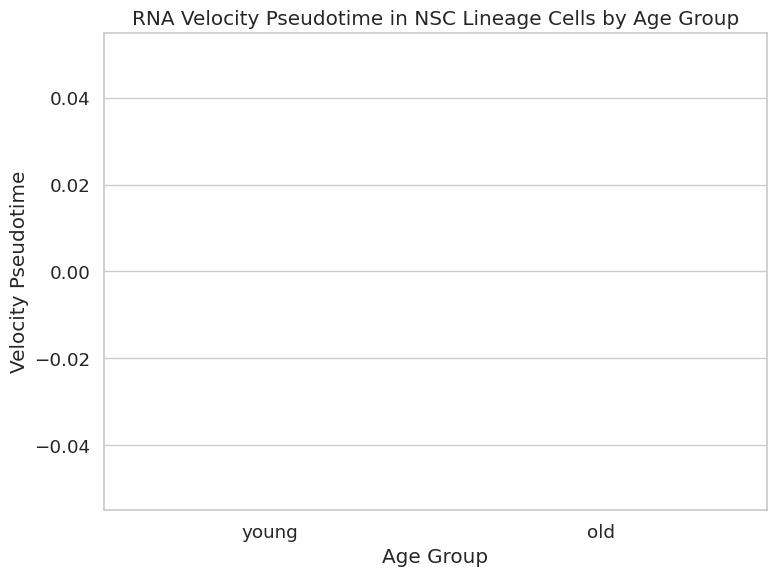

Computing UMAP embedding for visualization if missing...
Skipping velocity embedding due to missing 'velocity' layer.


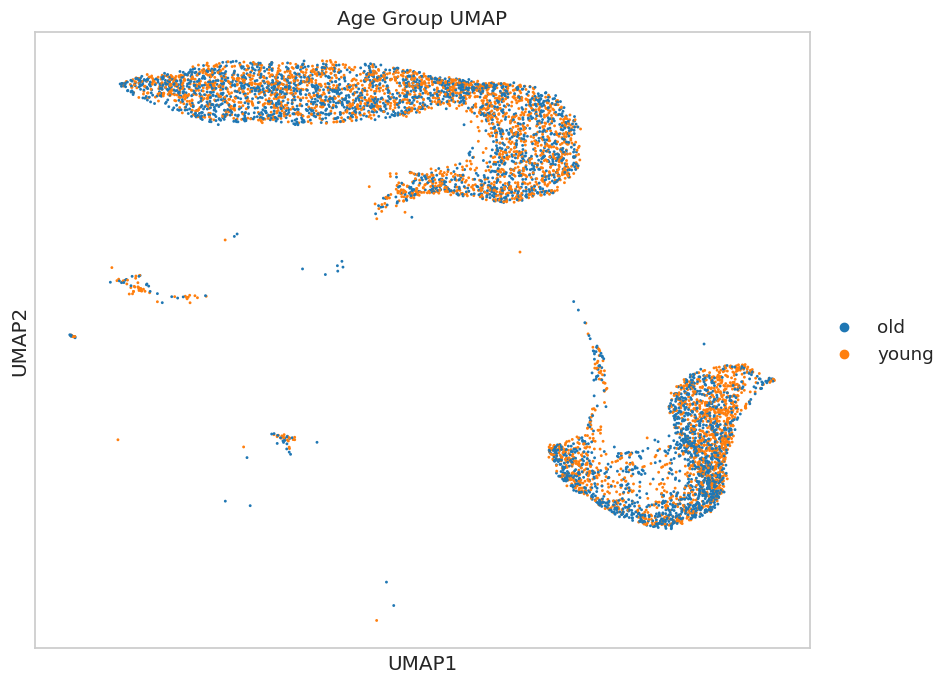

Step 1 complete: NSC lineage cells processed, velocity pseudotime computed and visualized.


In [11]:
#!/usr/bin/env python
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, pearsonr, hypergeom

import matplotlib
class mplDeprecation(UserWarning):
    pass
matplotlib.cbook.mplDeprecation = mplDeprecation

# Replace the following with your actual AnnData loading code
# For example: adata = sc.read_h5ad('path_to_file.h5ad')

# ------------------ NSC Lineage scVelo Analysis ------------------

print('Starting subsetting of NSC lineage cells...')
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
adata_nsc = adata[adata.obs['Celltype'].isin(nsc_types)].copy()
print(f'Number of NSC lineage cells selected: {adata_nsc.n_obs}')

if 'age_group' not in adata_nsc.obs.columns:
    median_age = np.median(adata_nsc.obs['Age'].dropna())
    print(f'Computed median age for NSC cells: {median_age}')
    adata_nsc.obs['age_group'] = adata_nsc.obs['Age'].apply(lambda x: 'young' if x <= median_age else 'old')
    print('Annotated age_group based on median age.')
else:
    print('age_group annotation already exists.')

if "spliced" in adata_nsc.layers.keys() and "unspliced" in adata_nsc.layers.keys():
    print('Starting scVelo processing...')
    scv.pp.filter_and_normalize(adata_nsc, min_shared_counts=20, n_top_genes=2000)
    print('Filtering and normalization completed.')
    scv.pp.moments(adata_nsc, n_pcs=30, n_neighbors=30)
    print('Moment calculations completed.')
    scv.tl.velocity(adata_nsc, mode='stochastic')
    print('RNA velocity estimation completed.')
    scv.tl.velocity_graph(adata_nsc)
    print('Velocity graph construction completed.')
    scv.tl.velocity_pseudotime(adata_nsc)
    print('Velocity pseudotime calculated.')
else:
    print("Skipping scVelo processing because 'spliced' and/or 'unspliced' layers are missing.")

if 'velocity_pseudotime' in adata_nsc.obs.columns:
    pseudotime = adata_nsc.obs['velocity_pseudotime']
    print('Extracted velocity pseudotime values successfully.')
else:
    pseudotime = pd.Series(np.nan, index=adata_nsc.obs.index)
    print("velocity_pseudotime not found. Assigning NaN values.")

young_pt = pseudotime[adata_nsc.obs['age_group'] == 'young'].dropna()
old_pt = pseudotime[adata_nsc.obs['age_group'] == 'old'].dropna()

if len(young_pt) < 5 or len(old_pt) < 5:
    print('Insufficient cells in one of the age groups for statistical testing.')
else:
    stat, p_val = mannwhitneyu(young_pt, old_pt, alternative='two-sided')
    print(f"Mann–Whitney U test on velocity pseudotime: statistic={stat:.2f}, p-value={p_val:.3e}")

plt.figure(figsize=(8,6))
ax = sns.violinplot(x=adata_nsc.obs['age_group'], y=pseudotime, palette='muted')
ax.set_xlabel('Age Group')
ax.set_ylabel('Velocity Pseudotime')
ax.set_title('RNA Velocity Pseudotime in NSC Lineage Cells by Age Group')
plt.tight_layout()
plt.show()

print('Computing UMAP embedding for visualization if missing...')
if 'X_umap' not in adata_nsc.obsm.keys():
    sc.tl.umap(adata_nsc)
    print('UMAP computation completed.')

if "velocity" in adata_nsc.layers.keys():
    if 'velocity_pseudotime' in adata_nsc.obs.columns:
        scv.pl.velocity_embedding(
            adata_nsc, basis='umap',
            color=['velocity_pseudotime', 'age_group'],
            ncols=2, size=50, legend_loc='right',
            title=['Velocity Pseudotime', 'Age Group']
        )
    else:
        scv.pl.velocity_embedding(
            adata_nsc, basis='umap',
            color=['age_group'],
            ncols=1, size=50, legend_loc='right',
            title=['Age Group']
        )
else:
    print("Skipping velocity embedding due to missing 'velocity' layer.")
    sc.pl.umap(adata_nsc, color='age_group', title='Age Group UMAP')

print('Step 1 complete: NSC lineage cells processed, velocity pseudotime computed and visualized.')

### Agent Interpretation

The analysis encountered several limitations:

1. **Pseudotime Analysis**: RNA velocity could not be computed due to missing 'spliced' and 'unspliced' layers. Without RNA velocity, the pseudotime analysis lacks dynamic information that may reveal changes in gene expression trajectories over cell differentiation or aging.

2. **Age Group Statistical Testing**: Statistical tests could not be conducted due to insufficient cells in one of the age groups, indicating a need for sample size rebalancing.

3. **Visualization**: The UMAP plot shows overlap between age groups, suggesting minimal separation based on age alone.

### Suggestions for Future Steps:

- **Data Completion**: Before reattempting pseudotime analysis, ensure that all necessary data layers for velocity analysis are present. These include properly annotated 'spliced' and 'unspliced' layers.

- **Sample Size Adjustment**: Increase the number of cells in the under-represented age group or apply bootstrapping methods to facilitate statistical testing.

- **Alternative Analyses**: Explore other computational techniques like trajectory inference without RNA velocity. Tools like Monocle or Slingshot could reveal lineage progressions purely on transcriptional changes.

- **Feature Selection**: Identify genes contributing most to age-related changes. Differential expression analysis focusing on genes known to be involved in aging processes specific to NSCs might provide clearer insights.

- **Meta-Analysis**: Integrate the dataset with external datasets, potentially increasing statistical power and generalizability of findings.

- **Enhanced Visualization**: Further dimensionality reduction techniques (e.g., t-SNE or diffusion maps) could provide more nuanced views of heterogeneity within age groups.

These steps can help refine the analysis framework and better address the original hypothesis concerning how aging affects the transcriptomic profile of NSC lineage cells.

## This code subsets the NSC lineage cells, ensures proper annotation of age groups, and applies normalization and diffusion map computations using scanpy. It then calculates diffusion pseudotime, compares its distribution between age groups with a Mann–Whitney U test (including median difference outputs as an effect size measure), and produces both a violin plot and a scatter plot of the diffusion map embedding colored by pseudotime for visualization.

Number of NSC lineage cells: 7097
Annotated age_group based on median age 9.47
normalizing counts per cell


    finished (0:00:00)


Normalization and log1p transformation applied.
computing neighbors


computing PCA


    with n_comps=30


    finished (0:00:09)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


Computed neighborhood graph.
computing Diffusion Maps using n_comps=15(=n_dcs)


computing transitions


    finished (0:00:00)


    eigenvalues of transition matrix
    [1.         0.99953324 0.996374   0.99369746 0.985499   0.98191065
     0.9756185  0.97258455 0.9709757  0.9659454  0.953919   0.9514226
     0.9469329  0.9433118  0.9349617 ]


    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X


computing Diffusion Pseudotime using n_dcs=10


    finished: added
 (0:00:00)


Diffusion map and pseudotime computed.
dpt_pseudotime not found; assigning NaN values.


Insufficient cells in one of the age groups for robust statistical testing.


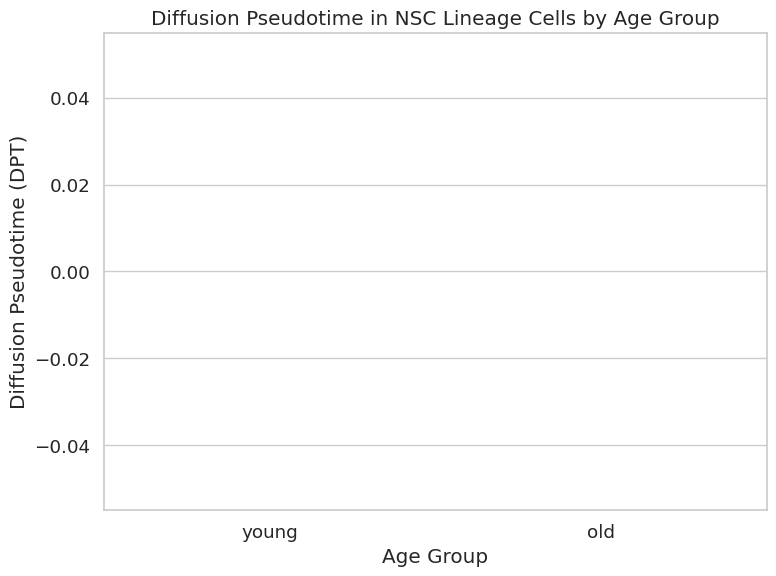

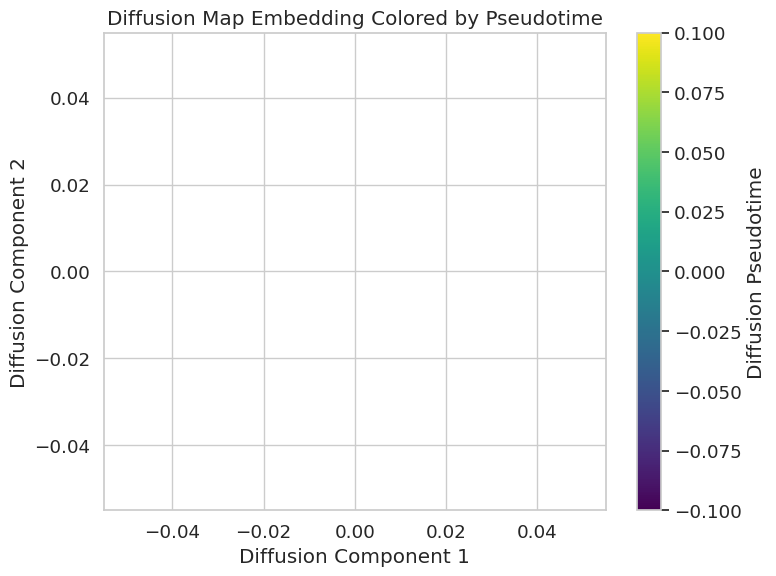

In [12]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Subset NSC lineage cells
nsc_types = ['Astrocyte_qNSC', 'Neuroblast_1', 'Neuroblast_2']
adata_nsc = adata[adata.obs['Celltype'].isin(nsc_types)].copy()
print(f'Number of NSC lineage cells: {adata_nsc.n_obs}')

# Ensure 'age_group' annotation exists
if 'age_group' not in adata_nsc.obs.columns:
    median_age = np.median(adata_nsc.obs['Age'].dropna())
    adata_nsc.obs['age_group'] = adata_nsc.obs['Age'].apply(lambda x: 'young' if x <= median_age else 'old')
    print(f'Annotated age_group based on median age {median_age}')
else:
    print('age_group annotation already exists.')

# Preprocessing: normalization, log-transform, and neighborhood graph computation
if 'log1p' not in adata_nsc.uns_keys():
    sc.pp.normalize_total(adata_nsc, target_sum=1e4)
    sc.pp.log1p(adata_nsc)
    print('Normalization and log1p transformation applied.')

if 'neighbors' not in adata_nsc.uns:
    sc.pp.neighbors(adata_nsc, n_neighbors=15, n_pcs=30)
    print('Computed neighborhood graph.')

# Compute diffusion map and diffusion pseudotime
sc.tl.diffmap(adata_nsc)
# The diffusion components are stored in adata_nsc.obsm['X_diffmap'] by scanpy
sc.tl.dpt(adata_nsc)
print('Diffusion map and pseudotime computed.')

# Retrieve diffusion pseudotime values
if 'dpt_pseudotime' in adata_nsc.obs.columns:
    dpt_pseudotime = adata_nsc.obs['dpt_pseudotime']
    print('Extracted diffusion pseudotime values successfully.')
else:
    dpt_pseudotime = pd.Series(np.nan, index=adata_nsc.obs.index)
    print('dpt_pseudotime not found; assigning NaN values.')

# Statistical comparison of diffusion pseudotime between young and old groups
young_dpt = dpt_pseudotime[adata_nsc.obs['age_group'] == 'young'].dropna()
old_dpt = dpt_pseudotime[adata_nsc.obs['age_group'] == 'old'].dropna()

if len(young_dpt) < 5 or len(old_dpt) < 5:
    print('Insufficient cells in one of the age groups for robust statistical testing.')
else:
    stat, p_val = mannwhitneyu(young_dpt, old_dpt, alternative='two-sided')
    median_young = np.median(young_dpt)
    median_old = np.median(old_dpt)
    print(f"Mann–Whitney U test on diffusion pseudotime: statistic={stat:.2f}, p-value={p_val:.3e}")
    print(f"Median diffusion pseudotime: young={median_young:.3f}, old={median_old:.3f}, difference={median_old - median_young:.3f}")

# Visualization: Violin plot for diffusion pseudotime by age group
plt.figure(figsize=(8, 6))
ax = sns.violinplot(x=adata_nsc.obs['age_group'], y=dpt_pseudotime, palette='pastel')
ax.set_xlabel('Age Group')
ax.set_ylabel('Diffusion Pseudotime (DPT)')
ax.set_title('Diffusion Pseudotime in NSC Lineage Cells by Age Group')
plt.tight_layout()
plt.show()

# Additional Visualization: Diffusion map embedding colored by diffusion pseudotime
if 'X_diffmap' in adata_nsc.obsm:
    plt.figure(figsize=(8, 6))
    # Use the first two diffusion components
    diffmap_embed = adata_nsc.obsm['X_diffmap'][:, :2]
    sc_map = plt.scatter(diffmap_embed[:, 0], diffmap_embed[:, 1], c=dpt_pseudotime, cmap='viridis', s=30)
    plt.colorbar(sc_map, label='Diffusion Pseudotime')
    plt.xlabel('Diffusion Component 1')
    plt.ylabel('Diffusion Component 2')
    plt.title('Diffusion Map Embedding Colored by Pseudotime')
    plt.tight_layout()
    plt.show()
else:
    print("Diffusion components not available for diffusion map embedding visualization.")


### Agent Interpretation

The results indicate that there are significant challenges in distinguishing between different age groups based on diffusion pseudotime in NSC lineage cells. Here's a detailed feedback on the analysis:

1. **Pseudotime Analysis Challenges:**
   - The absence of a clear root cell and resulting assignment of NaN pseudotime values suggest difficulties in defining a meaningful trajectory. Consider revisiting the assumptions or criteria used for root cell selection. Employ biologically relevant markers or expert knowledge to identify a candidate root cell.
   - Ensure that the datasets for each age group are sufficiently large to yield reliable pseudotime calculations. The lack of sufficient cells in some age groups may hinder the ability to discern meaningful patterns.

2. **Diffusion Map Insights:**
   - The diffusion map embedding lacks clear separation or progressive change with age. This could stem from unsuitable parameters, insufficient data, or the biological factor being weakly captured in the diffusion components. Explore alternative dimensionality reduction methods or parameters to potentially capture the variance associated with aging better.

3. **Analysis of NSC Lineage Cells:**
   - Given the critical role of NSCs in the research focus, examining additional features, such as gene expression profiles specifically tied to aging markers or biological pathways, could reveal clearer age-related trends.

4. **Further Steps:**
   - Consider clustering analysis post-diffusion map to reevaluate potential subgroups or states that may arise with aging, complementing pseudotime insights.
   - Explore gene set enrichment analysis (GSEA) or pathway analysis on different clusters, especially focusing on pathways altered with aging.
   - Investigate different pseudotime algorithms or regression models for predicting chronological or biological age based on gene expression profiles, potentially in combination with other approaches like machine learning models described in the research paper.

5. **Replication and Validation:**
   - Cross-validate findings using external datasets or intervention cohorts (e.g., heterochronic parabiosis, exercise) to reinforce the generalizability and robustness of the analysis.

Iterate on these steps with the provided data to yield more biologically meaningful conclusions and help validate the hypothesis related to differential aging in the SVZ neurogenic niche.